In [2]:
import numpy as np
import json
import matplotlib.pyplot as plt 
from scipy.spatial import Delaunay 
import skimage as sk
import scipy as sci
import cv2
import os 
from scipy.interpolate import interp2d


In [3]:
os.getcwd()

'/Users/admin/CS180/Morphing/src'

In [128]:
#Triangle Vert is a 3x2 array
def imgToTriangle(triangleVert, img):
    triangleVert = np.array(triangleVert)
    centroid = np.array([np.average(triangleVert[:, 0]), np.average(triangleVert[:, 1])])
    for idx in range(0, triangleVert.shape[0]):
        direction = triangleVert[idx] - centroid
        direction = direction/np.linalg.norm(direction)
        expandedVertex = triangleVert[idx] + direction * 0
        triangleVert[idx] = expandedVertex
    mask = sk.draw.polygon2mask(img.shape[0:3], triangleVert)
    # print(mask.shape)
    return img * mask
   #return np.stack(img[:,:,0] * mask, img[:,:,1] * mask, img[:,:,2] * mask, axis=2)

In [16]:
#Inverse transform from t1 to t2
def affineTrans(triIndex, t1Points, t1Simplicies, t2Points):
    t1 = [t1Points[i] for i in t1Simplicies[triIndex]]
    t2 = [t2Points[i] for i in t1Simplicies[triIndex]]
    # print(t1)
    # print(t2)
    t1Vec = np.array([t1[0] - t1[1],  t1[0] - t1[2]]).T
    t2Vec = np.array([t2[0] - t2[1],  t2[0] - t2[2]]).T
    # print(t1Vec)
    # print(t2Vec)
    t1VecToRight = np.eye(3)
    t1VecToRight[0:2, 0:2] = t1Vec
    t1VecToRight[0:2, 2] = t1[0]
    t1VecToRight = np.linalg.inv(t1VecToRight)

    rightToT2 = np.eye(3)
    rightToT2[0:2, 0:2] = t2Vec
    rightToT2[0:2, 2] = t2[0]

    return rightToT2 @ t1VecToRight
    

In [137]:
def warpImg(im1Points, im1Tri, im2Points, img):
    warpedIm2 = np.zeros_like(img).astype(np.float64)
    for i in range(0, len(im1Tri.simplices)):
        maskedIm2 = imgToTriangle([[im2Points[i][1],im2Points[i][0]] for i in im1Tri.simplices[i]], img)
        inverseMap = affineTrans(i, im1Points, im1Tri.simplices, im2Points)
        triangle = np.clip(sk.transform.warp(maskedIm2, inverseMap), 0, 1)
        warpedIm2 += triangle
        # print(np.percentile(triangle, 20))
        np.add(triangle, warpedIm2, where = np.all(warpedIm2 == 0), out=warpedIm2)
        # print(np.argwhere(warpedIm2 > 1).shape)
    return warpedIm2

In [115]:
arr = np.array([0,0,0])
arr == 0

array([ True,  True,  True])

In [148]:
def warpWithRatio(im1, im1Points, im2, im2Points, crossRatio, morphRatio):
    # averageImg = np.average([im2Points[0], im2Points[0]], weights=[morphRatio, 1-morphRatio], axis=0)
    averagePoints = [np.average(a, weights=[morphRatio, 1-morphRatio], axis=0) for a in zip(im1Points, im2Points)]
    averagePoints = np.array(averagePoints) 
    triAverage = Delaunay(averagePoints)
    img1Warp = warpImg(averagePoints, triAverage, im1Points, im1)
    img2Warp = warpImg(averagePoints, triAverage, im2Points, im2)
    interpolatedImg = img1Warp * crossRatio + img2Warp * (1-crossRatio)
    interpolatedImg = np.clip(interpolatedImg, 0, 1)
    
    return interpolatedImg


In [73]:
im1 = plt.imread('../../Morphing/Photos/diddyRescaled.jpg')
im2 = plt.imread('../../Morphing/Photos/thomasRescaled.jpg')

In [142]:
with open('../../Morphing/Photos/corr.json') as jsonFile:
    keyPoints = json.load(jsonFile)
keyPoints['im1Points'].extend([[0,im2.shape[0]], [im2.shape[1],im2.shape[0]], [0,0], [im2.shape[1],0]])
keyPoints['im1Points'].extend([[0,im2.shape[0]//2], [im2.shape[1],im2.shape[0]//2], [im2.shape[1]//2,im2.shape[0]], [im2.shape[1]//2,0]])
keyPoints['im2Points'].extend([[0,im2.shape[0]], [im2.shape[1],im2.shape[0]], [0,0], [im2.shape[1],0]])
keyPoints['im2Points'].extend([[0,im2.shape[0]//2], [im2.shape[1],im2.shape[0]//2], [im2.shape[1]//2,im2.shape[0]], [im2.shape[1]//2,0]])

In [143]:
im1Points = np.array(keyPoints['im1Points'])
im2Points = np.array(keyPoints['im2Points'])

In [153]:
for i in range(0, 11):
    print(f"loop {i}")
    test = warpWithRatio(im1, im1Points, im2, im2Points, 0.1 * i, 0.1 * i)
    plt.imsave(f'../morphOut/test/output_{i}.png', test)

loop 0
loop 1
loop 2
loop 3
loop 4
loop 5
loop 6
loop 7
loop 8
loop 9
loop 10


In [149]:
np.max(test)

4.558074752140561

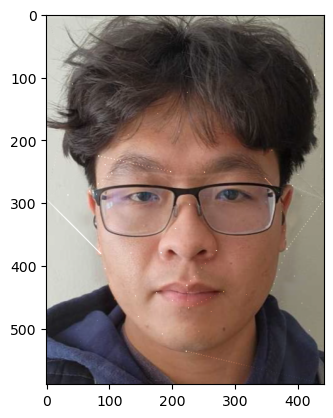

In [152]:
plt.imshow(test)

In [835]:
test1 = test.copy()
test1[test1 > 1] = 0

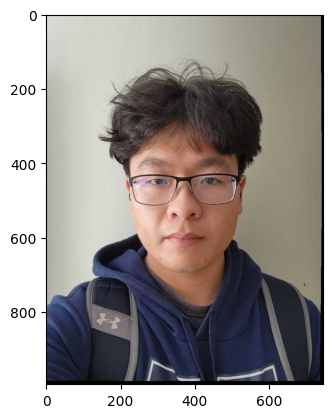

In [836]:
plt.imshow(test1)
plt.imsave('../testing/output.png', test1)

In [106]:
from scipy.interpolate import griddata

In [111]:
grid_x, grid_y = np.mgrid[0:test.shape[0], 0:test.shape[1]]
points = np.meshgrid(np.linspace(0, test.shape[0]), np.linspace(0, test.shape[1]))
print(test[:,:,0].shape)
print(len(points))
grid_z0 = griddata(points, test[:,:,0], (grid_x, grid_y), method='nearest')


(995, 746)
2


ValueError: different number of values and points